In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import glob, os
import torch
import numpy as np

In [2]:
summary_yaml = '/pscratch/sd/z/zhantao/inxs_steering_production/benchmarks/summary.yaml'

In [3]:
import yaml

with open(summary_yaml, 'r') as file:
    summary_dict = yaml.safe_load(file)


In [4]:
steps_of_interest = [25, 50]

In [5]:
mean_preds = []
true_values = []
sample_ids = []
maes = []

for path in summary_dict['real']['gaussian_0.1_scaled']:
    pt_flist = glob.glob(os.path.join(summary_dict['path'], path, '*.pt'))
    pt_indices = sorted([int(_.split('/')[-1].split('.')[0]) for _ in pt_flist])

    for _idx, _idx in enumerate(pt_indices):
        _pt = torch.load(os.path.join(summary_dict['path'], path, f'{_idx:02d}.pt'))
        # print(_pt.keys())
        _mean_preds = (_pt['positions'] * _pt['weights'].unsqueeze(-1)).sum(dim=-2) / _pt['weights'].sum(dim=-1).unsqueeze(-1)
        
        # _mean_preds = _pt['means']
        
        _maes = (_mean_preds - _pt['true_params'][None]).norm(dim=-1)
        
        mean_preds.append(_mean_preds.unsqueeze(0))
        maes.append(_maes[steps_of_interest].unsqueeze(0))
        sample_ids.append(_idx)
        true_values.append(_pt['true_params'])

maes = torch.vstack(maes).numpy()
mean_preds = torch.vstack(mean_preds).numpy()
sample_ids = torch.tensor(sample_ids).numpy()
true_values = torch.vstack(true_values).numpy()

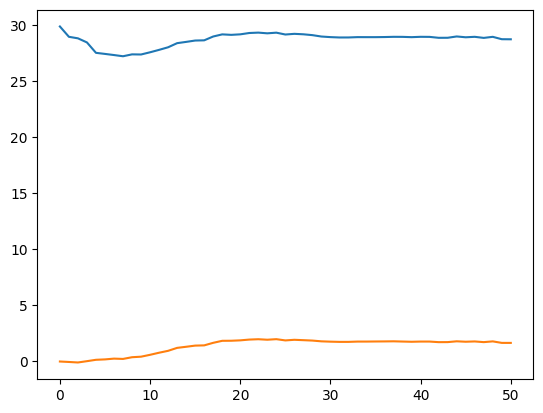

In [6]:
plt.plot(_mean_preds)

Text(0, 0.5, 'Count')

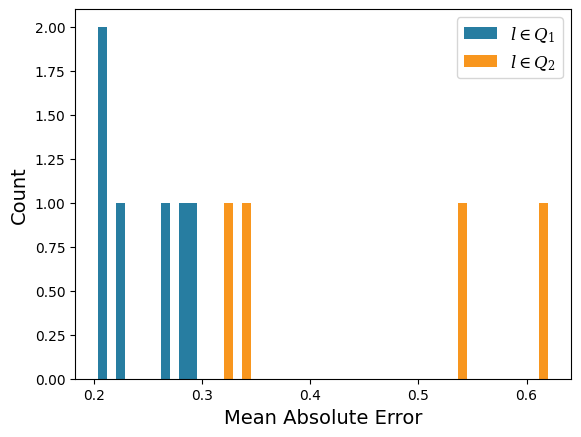

In [32]:
mae_sorted_quartiles_idx = np.split(np.argsort(maes[:,-1]), 2)
mae_sorted_quartiles = np.split(np.sort(maes[:,-1]), 2)

# fig, ax = plt.subplots(1,1)
# ax.hist(maes[:,-1], bins=60)
# mae_sorted_quartiles = np.split(np.sort(maes[:,-1]), 4)

fig, ax = plt.subplots(1,1)
n, bins, patches = ax.hist(maes[:,-1], bins=50)

bin_centers = 0.5 * (bins[:-1] + bins[1:])

start_ids = []
for i in range(len(mae_sorted_quartiles)):
    start = np.where(bin_centers > mae_sorted_quartiles[i].min())[0][0]
    start_ids.append(start)
    for patch in patches[start:]:
        patch.set_facecolor(f'C{i}')
        
# Add legend for each color
legend_labels = [fr'$l\in Q_{_j+1}$' for _j in range(len(mae_sorted_quartiles))]
legend_patches = [patches[start] for start in start_ids]
ax.legend(legend_patches, legend_labels, fontsize=12)

ax.set_xlabel('Mean Absolute Error', fontdict={'size': 14})
ax.set_ylabel('Count', fontdict={'size': 14})


# ax.set_xlabel('Mean Absolute Error', fontdict={'size': 14})
# ax.set_ylabel('Count', fontdict={'size': 14});

In [33]:
mae_sorted_quartiles_idx = np.split(np.argsort(maes[:60,-1]), 2)
mae_sorted_quartiles = np.split(np.sort(maes[:60,-1]), 2)

rdn_idx = np.random.choice(mae_sorted_quartiles_idx[0], 2, replace=False)

# rdn_idx = np.random.choice(mae_sorted_quartiles_idx[1], 3)

In [34]:
plt.rcParams["mathtext.fontset"] = "cm"

In [35]:
import config_matplotlib

In [36]:
config_matplotlib.config_matplotlib()

/global/u2/z/zhantao/Projects/inxs_steering/paper_preperation/config_matplotlib.py:38: UserWarning: Trying to register the cmap 'custom_cmap' which already exists.
  plt.register_cmap(cmap=custom_cmap)


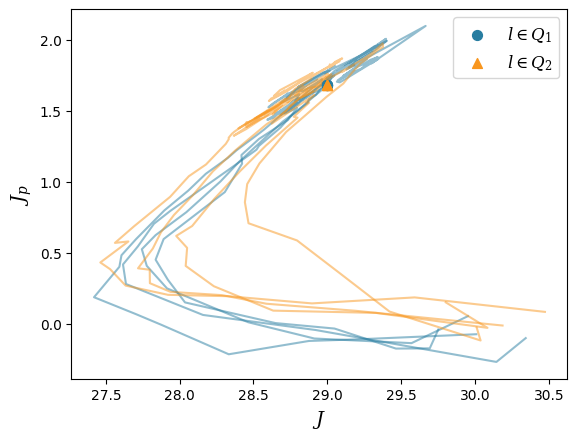

In [37]:
N_samp = mean_preds.shape[1]

N_samp_interp = 100

step = 20

markers = ['o', '^', 's', 'd']
fig, ax = plt.subplots(1,1)
for _j in range(2):
    
    np.random.seed(10)
    rdn_idx = np.random.choice(mae_sorted_quartiles_idx[_j], 4, replace=False)
    for _idx in rdn_idx:
        
        ax.plot(mean_preds[_idx,:,0], mean_preds[_idx,:,1], color=f'C{_j}', alpha=0.5, zorder=1)
        
        ax.scatter(true_values[_idx,0], true_values[_idx,1], 
                   color=f'C{_j}', marker=markers[_j], zorder=10, s=50,
                   label=fr'$l\in Q_{_j+1}$' if _idx==rdn_idx[0] else None)
        
ax.set_xlabel('$J$', fontdict={'size': 14})
ax.set_ylabel('$J_{p}$', fontdict={'size': 14})
# ax.set_xlim(20, 40)
# ax.set_ylim(-5, 5)
ax.legend(fontsize=12)

In [38]:
unique_ids = set(sorted(sample_ids.tolist()))

IndexError: index 12 is out of bounds for axis 0 with size 10

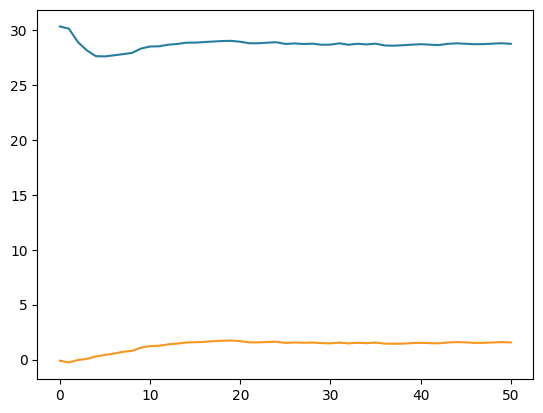

In [39]:
demo_ids = [12]

fig, ax = plt.subplots(1,1)
# ax.plot(mean_preds[demo_ids,:,0].mean(axis=0), label='$J$')
# ax.plot(mean_preds[demo_ids,:,1].mean(axis=0), label='$J_{p}$')

ax.plot(_pt['means'])

# ax.plot(mean_preds[demo_ids[0],:,0], label='$J$')
# ax.plot(mean_preds[demo_ids[0],:,1], label='$J_{p}$')

# if len(demo_ids) > 1:
#     ax.fill_between(np.arange(51), 
#                     mean_preds[demo_ids,:,0].mean(axis=0) - mean_preds[demo_ids,:,0].std(axis=0), 
#                     mean_preds[demo_ids,:,0].mean(axis=0) + mean_preds[demo_ids,:,0].std(axis=0), alpha=0.3)
#     ax.fill_between(np.arange(51), 
#                     mean_preds[demo_ids,:,1].mean(axis=0) - mean_preds[demo_ids,:,1].std(axis=0), 
#                     mean_preds[demo_ids,:,1].mean(axis=0) + mean_preds[demo_ids,:,1].std(axis=0), alpha=0.3)

ax.hlines(true_values[demo_ids[0]], 0, 51, color='gray', linestyles='dashed')
# ax.legend(fontsize=14)

ax.set_xlabel('Measurement Iterations', fontdict={'size': 14})
ax.set_ylabel('Parameter Values', fontdict={'size': 14});

Text(0, 0.5, 'Measured Angle (deg)')

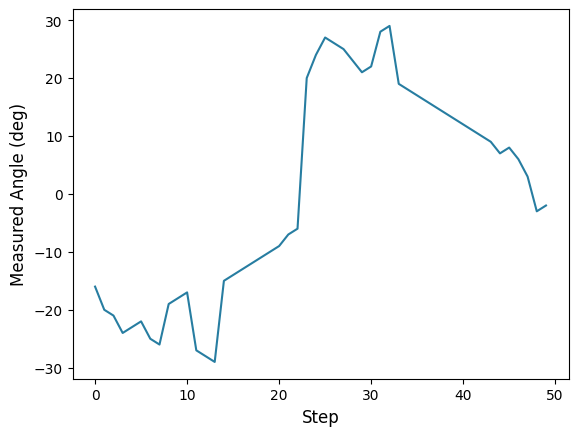

In [57]:
measured_angles = _pt['measured_angles']
measured_angles[measured_angles > 180] -= 360

fig, ax = plt.subplots(1,1)

ax.plot(measured_angles)
ax.set_xlabel('Step')
ax.set_ylabel('Measured Angle (deg)')

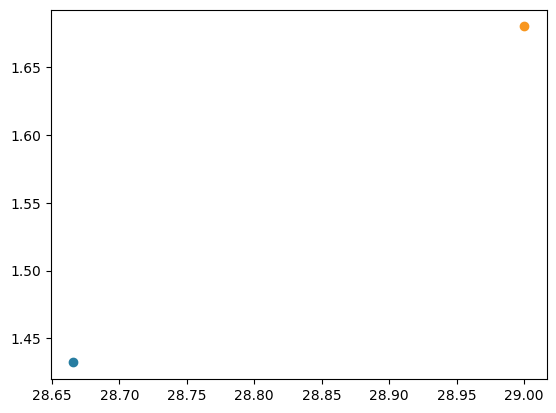

In [29]:

fig, ax = plt.subplots(1,1)
ax.scatter(*mean_preds[demo_ids,-1].mean(axis=0))
ax.scatter(*true_values[demo_ids[0]])

In [30]:
from sklearn.neighbors import KernelDensity
import numpy as np

In [31]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(_pt['positions'][-1], sample_weight=_pt['weights'][-1])

In [32]:
J, Jp = np.meshgrid(np.linspace(20, 40, 401), np.linspace(-5, 5, 201))
param_grid = np.concatenate([J[..., None], Jp[..., None]], axis=-1)

In [11]:
log_density = kde.score_samples(param_grid.reshape(-1, 2)).reshape(J.shape)

/pscratch/sd/z/zhantao/conda/inxs/lib/python3.9/site-packages/sklearn/neighbors/_kde.py:271: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


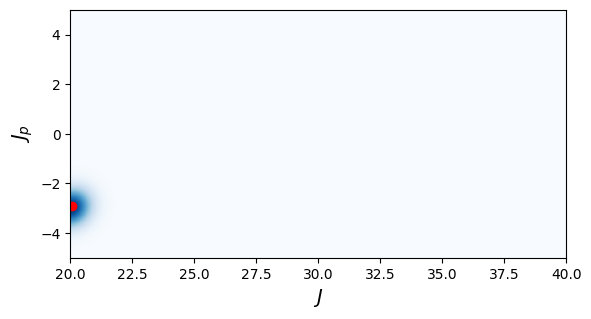

In [12]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.exp(log_density), origin='lower', extent=[20, 40, -5, 5], aspect='equal', cmap='Blues')
ax.scatter(_pt['true_params'][0], _pt['true_params'][1], color='red')
ax.set_xlabel('$J$', fontdict={'size': 14})
ax.set_ylabel('$J_{p}$', fontdict={'size': 14});